# Setting up

In [1]:
# %pip install matplotlib
# %pip install tensorflow==2.14.0
# %pip install innvestigate==2.1.2

In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# Reconstruct Model

## Define the architecture that was made before

In [3]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model

input_shape = (256, 256, 3)
input_layer = Input(shape=input_shape)

base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_layer)
base_model.trainable=False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)

output_layer = Dense(9, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

Instructions for updating:
Colocations handled automatically by placer.


## Load the saved weight

In [4]:
model.load_weights('../src/models/dense_net_model_weight.h5')

## Remove softmax

In [5]:
import innvestigate

model = innvestigate.model_wo_softmax(model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']      

# Create LRP analyzer

In [6]:
from innvestigate.analyzer import LRPSequentialPresetBFlat

analyzer = LRPSequentialPresetBFlat(model, reverse_verbose=True)

# Preprocess input image

In [7]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
import numpy as np

# Load an image
img_path = "../data/test/Bacterial Leaf Blight/aug_0_14.jpg"
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

In [8]:
img_array.shape

(1, 256, 256, 3)

# Get Relevance Heatmap

In [9]:
relevance = analyzer.analyze(img_array)

Reverse model: <keras.src.engine.functional.Functional object at 0x000001F3D3BD41F0>


c:\Users\steam\AppData\Local\Programs\Python\Python310\lib\site-packages\innvestigate\backend\graph.py:467: UserWarning: Ignore dtype <dtype: 'float32'> as bias type.
  warnings.warn(f"Ignore dtype {dtype} as bias type.")
c:\Users\steam\AppData\Local\Programs\Python\Python310\lib\site-packages\innvestigate\backend\graph.py:480: UserWarning: Ignore dtype <dtype: 'float32'> as bias type.
  warnings.warn(f"Ignore dtype {dtype} as bias type.")


[NID: 429] Reverse layer-node <innvestigate.layers.MaxNeuronSelection object at 0x000001F3D61CFB80>
[NID: 428] Reverse layer-node <keras.src.layers.core.dense.Dense object at 0x000001F3D61CF9D0>
[NID: 427] Reverse layer-node <keras.src.layers.core.dense.Dense object at 0x000001F3D60C0610>
[NID: 426] Reverse layer-node <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001F3CB80A260>
[NID: 425] Reverse layer-node <keras.src.layers.core.activation.Activation object at 0x000001F3D3B72B90>
[NID: 424] Reverse layer-node <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F3D3B72CE0>
[NID: 423] Reverse layer-node <keras.src.layers.merging.concatenate.Concatenate object at 0x000001F3D2B4C2B0>
[NID: 422] Reverse layer-node <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001F3D3B72A40>
[NID: 421] Reverse layer-node <keras.src.layers.core.activation.Activation object at 0x000001F3D2AE2B30>
[NID: 420] Reverse 

KeyboardInterrupt: 

# LRP Visualization

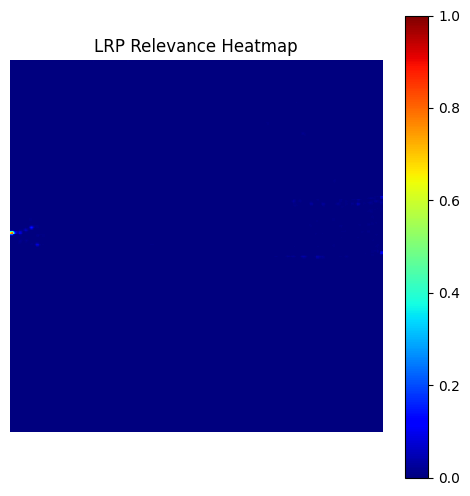

In [ ]:
import matplotlib.pyplot as plt

# Aggregate along color channels and normalize to [-1, 1]
relevance_visualization = relevance.sum(axis=np.argmax(np.asarray(relevance.shape) == 3))
relevance_visualization /= np.max(np.abs(relevance_visualization))

# Plot
plt.imshow(relevance_visualization[0], cmap="seismic", clim=(-1, 1))